In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord

from gaia_kepler import data, tgas_match

% matplotlib inline

### Crossmatch the Kepler Eclipsing Binary Catalog
http://keplerebs.villanova.edu/

In [2]:
# Load EBs from the original Kepler mission
kebc = pd.read_csv('data/kebc.csv', comment='#')

# Load EBs from the K2 mission
k2ebc = pd.read_csv('data/k2ebc.csv', comment='#')

In [3]:
# Match to TGAS
kebc_in_tgas = tgas_match(kebc)
k2ebc_in_tgas = tgas_match(k2ebc)

print len(kebc_in_tgas)
print len(k2ebc_in_tgas)

324
145


In [4]:
# Save to CSV
kebc_in_tgas.to_csv('data/kebc_in_tgas.csv')
k2ebc_in_tgas.to_csv('data/k2ebc_in_tgas.csv')

### Crossmatch SB9 (spectroscopic binaries)
http://sb9.astro.ulb.ac.be/

http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=B/sb9

SB9 is comprised of three tables

* main: positions, magnitudes, and spectral types
* orbits: orbital parameters
* alias: other designations

I joined the main and orbits tables on VizieR, matching by system number (Seq). Some systems have multiple orbits, so take the orbit with the best grade. grade 0 = poor, grade 5 = definitive.

I'm using the decimal RA and DEC computed by VizieR in FK5.

In [5]:
sb9 = pd.read_csv('data/sb9_join.tsv', delimiter='|', comment='#')

In [6]:
# Only keep systems with orbit grades >= 3
sb9 = sb9[sb9['Grade'].astype(int) >= 3]

In [7]:
# For duplicates, keep orbits with the higher grade
sb9 = sb9.sort_values(['Seq', 'Grade'], ascending=[True, False])
sb9 = sb9.drop_duplicates(subset='Seq')

In [8]:
sb9_in_tgas = tgas_match(sb9)
print len(sb9_in_tgas)

721


In [9]:
sb9_in_tgas.to_csv('data/sb9_in_tgas.csv')

### Crossmatch the Sixth Catalog of Orbits of Visual Catalogs
http://www.usno.navy.mil/USNO/astrometry/optical-IR-prod/wds/orb6

I'm only keeping systems with orbital solutions graded as 1 (definitive), 2 (good), or 3 (reliable).

In [10]:
vb6 = pd.read_csv('data/visual_6_orbits.sql', delimiter='|', comment='#', 
                  dtype={'ra_str': str, 'dec_str': str})

# Only keep systems with grade 3 or better
vb6 = vb6[vb6['G'] <= 3]

In [11]:
# Convert period in years to days
vb6.loc[:, 'period_days'] = vb6['period']
vb6.loc[vb6['period_units'] == 'y', 'period_days'] = vb6['period'][vb6['period_units'] == 'y'] * 365.2422 

In [12]:
def decimal_degrees(ra_str, dec_str):
    """
    Convert the Visual Binary Catalog RA and DEC to decimal degrees.
    
    Parameters
    ----------
    ra_str, dec_str : str
        RA in HHMMSS, DEC in DDMMSS
    
    Returns
    -------
    ra_deg, dec_deg : float
        RA and DEC in decimal degrees
    """
    new_ra_str = '{}h{}m{}s'.format(ra_str[:2], ra_str[2:4], ra_str[4:])
    new_dec_str = '{}d{}m{}s'.format(dec_str[:3], dec_str[3:5], dec_str[5:])
    
    coord = SkyCoord(new_ra_str, new_dec_str, frame='icrs')
    
    return coord.ra.deg, coord.dec.deg

In [13]:
# "Empty" arrays for RA and DEC
ra_deg = np.repeat([-1.], len(vb6))
dec_deg = np.repeat([-99.], len(vb6))

In [14]:
for ii, index in enumerate(vb6.index):
    ra, dec = decimal_degrees(vb6['ra_str'][index], vb6['dec_str'][index])
    ra_deg[ii] = ra
    dec_deg[ii] = dec

In [15]:
# Add columns to DataFrame
vb6.loc[:, 'ra'] = ra_deg
vb6.loc[:, 'dec'] = dec_deg

In [16]:
vb6_in_tgas = tgas_match(vb6)
print len(vb6_in_tgas)

105


In [17]:
vb6_in_tgas.to_csv('data/vb6_in_tgas.csv')

### Concatenate the catalogs

In [18]:
tgas_columns = vb6_in_tgas.columns[np.array(['tgas' in column for column in vb6_in_tgas.columns])]

In [20]:
# Keep orbital period, catalog identifiers, and TGAS columns
kebc_to_concat = kebc_in_tgas[np.concatenate([['period', 'KIC'], tgas_columns])]
k2ebc_to_concat = k2ebc_in_tgas[np.concatenate([['period', 'EPIC'], tgas_columns])]

sb9_to_concat = sb9_in_tgas[np.concatenate([['Per', 'Seq'], tgas_columns])]
sb9_to_concat.rename(columns={'Per': 'period', 'Seq': 'sb9_id'}, inplace='True')

vb6_to_concat = vb6_in_tgas[np.concatenate([['period_days', 'WDS'], tgas_columns])]
vb6_to_concat.rename(columns={'period_days': 'period'}, inplace='True')

In [21]:
# Concatenate DataFrames
all_systems = pd.concat([kebc_to_concat, k2ebc_to_concat, sb9_to_concat, vb6_to_concat], ignore_index=True)
print 'Total binaries: {}'.format(len(all_systems))

Total binaries: 1295


In [22]:
# Populate a binary_type column
all_systems.loc[:, 'binary_type'] = np.repeat(['None'], len(all_systems))

eb_mask = np.isfinite(all_systems['KIC']) | np.isfinite(all_systems['EPIC'])
all_systems.loc[eb_mask, 'binary_type'] = 'EB'

sb_mask = np.isfinite(all_systems['sb9_id'])
all_systems.loc[sb_mask, 'binary_type'] = 'SB'

all_systems['WDS'].fillna(value='', inplace=True)
vb_mask = all_systems['WDS'] != ''
all_systems.loc[vb_mask, 'binary_type'] = 'VB'

In [23]:
all_systems.to_csv('combined_catalog.csv')

### Plot the orbital period distributions of the crossmatches

In [24]:
log_period_bins = np.arange(-1.5, 5.5, 0.25)

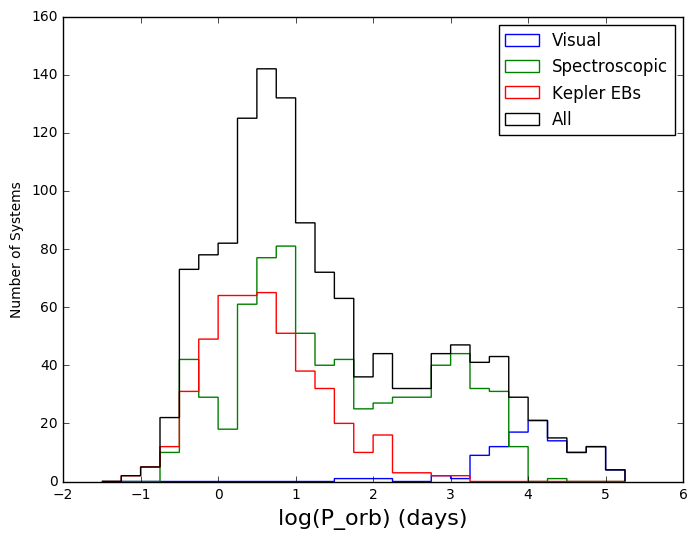

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(np.log10(all_systems[all_systems['binary_type'] == 'VB']['period']), 
         bins=log_period_bins, histtype='step', label='Visual')
plt.hist(np.log10(all_systems[all_systems['binary_type'] == 'SB']['period']), 
         bins=log_period_bins, histtype='step', label='Spectroscopic')
plt.hist(np.log10(all_systems[all_systems['binary_type'] == 'EB']['period']), 
         bins=log_period_bins, histtype='step', label='Kepler EBs')
plt.hist(np.log10(all_systems['period']), bins=log_period_bins, histtype='step', color='k', label='All')

plt.xlabel('log(P_orb) (days)', fontsize=16)
plt.ylabel('Number of Systems')
plt.legend()
plt.show()